In [1]:
import matplotlib.pyplot as plt
import patoolib
import zarr
import os
import xarray as xr
from tqdm import tqdm
import numpy as np

INPUT_PATH = 'data/1200.zarr.rar'
OUTPUT_PATH = 'data/image_new'
ZARR_FILE = os.path.join(OUTPUT_PATH, '1200.zarr')

if not os.path.exists('data/image_new'):
    os.makedirs('data/image_new')

if not os.path.exists(ZARR_FILE):
    patoolib.extract_archive(INPUT_PATH, outdir=OUTPUT_PATH)

# Open the zarr store
store = zarr.open(ZARR_FILE, mode="r")

# Check top-level keys
print(store.tree())  # prints

ds = xr.open_zarr(ZARR_FILE)
print(ds)

/
├── heightAboveSea () float64
├── latitude (3500,) float64
├── longitude (7000,) float64
├── step () float64
├── time (2000,) int64
├── unknown (2000, 3500, 7000) float16
└── valid_time (2000,) float64


<xarray.Dataset> Size: 98GB
Dimensions:         (time: 2000, latitude: 3500, longitude: 7000)
Coordinates:
    heightAboveSea  float64 8B ...
  * time            (time) datetime64[ns] 16kB 2022-01-01 ... 2022-01-03T18:4...
  * latitude        (latitude) float64 28kB 54.99 54.98 54.98 ... 20.02 20.01
    step            timedelta64[ns] 8B ...
  * longitude       (longitude) float64 56kB 230.0 230.0 230.0 ... 300.0 300.0
    valid_time      (time) datetime64[ns] 16kB ...
Data variables:
    unknown         (time, latitude, longitude) float16 98GB ...
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             161
    GRIB_centreDescription:  161
    GRIB_edition:            2
    GRIB_subCentre:          0
    history:                 2022-05-18T13:06 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             161


In [17]:
import json

DBZ_THRESHOLD = 25

DBZ_PIXEL_COUNTS_PATH = os.path.join('data/dbz_pixel_counts.json')
with open(DBZ_PIXEL_COUNTS_PATH, 'r') as f:
    DBZ_PIXEL_COUNTS = json.load(f)

np.argmax(DBZ_PIXEL_COUNTS), np.max(DBZ_PIXEL_COUNTS)

(np.int64(1479), np.int64(6484))

In [25]:
(ds.unknown[np.argmax(DBZ_PIXEL_COUNTS)] > DBZ_THRESHOLD).sum().item()

6453

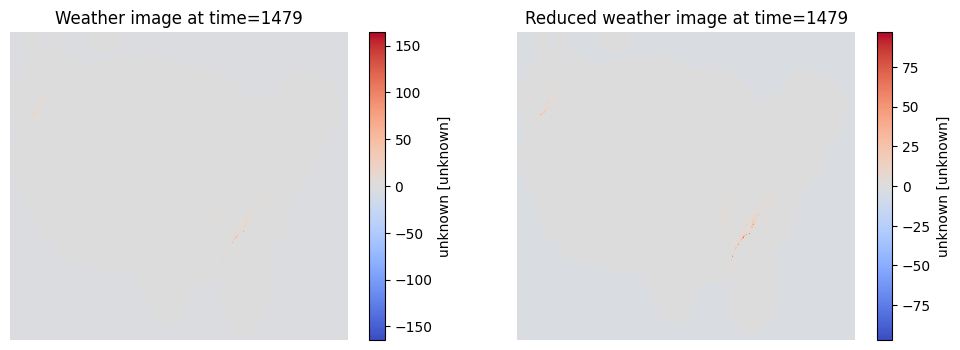

In [37]:
time = np.argmax(DBZ_PIXEL_COUNTS)
da = ds.unknown[np.argmax(DBZ_PIXEL_COUNTS)]  # 2D slice at first time index

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
da.plot(cmap="coolwarm")  # or "coolwarm", "jet"
plt.title(f"Weather image at time={time}".format(time=time))
plt.axis('off')

plt.subplot(1, 2, 2)
da_coarse = da.coarsen(latitude=4, longitude=4, boundary="trim").mean()

da_coarse.plot(cmap="coolwarm")
plt.title(f"Reduced weather image at time={time}".format(time=time))
plt.axis('off')

plt.show()

In [28]:
(da_coarse > 25).sum().item()

385

In [36]:
da_coarse.values.ravel(), da_coarse

(array([-3., -3., -3., ..., -3., -3., -3.], shape=(1531250,), dtype=float16),
 <xarray.DataArray 'unknown' (latitude: 875, longitude: 1750)> Size: 3MB
 array([[-3., -3., -3., ..., -3., -3., -3.],
        [-3., -3., -3., ..., -3., -3., -3.],
        [-3., -3., -3., ..., -3., -3., -3.],
        ...,
        [-3., -3., -3., ..., -3., -3., -3.],
        [-3., -3., -3., ..., -3., -3., -3.],
        [-3., -3., -3., ..., -3., -3., -3.]],
       shape=(875, 1750), dtype=float16)
 Coordinates:
     heightAboveSea  float64 8B ...
     time            datetime64[ns] 8B 2022-01-03T01:20:00
   * latitude        (latitude) float64 7kB 54.98 54.94 54.9 ... 20.1 20.06 20.02
     step            timedelta64[ns] 8B ...
   * longitude       (longitude) float64 14kB 230.0 230.1 230.1 ... 299.9 300.0
     valid_time      datetime64[ns] 8B ...
 Attributes: (12/29)
     GRIB_NV:                                  0
     GRIB_Nx:                                  7000
     GRIB_Ny:                               

In [33]:
export_folder = os.path.join(OUTPUT_PATH, "images")
if not os.path.exists(export_folder):
    os.makedirs(export_folder)

export_file = os.path.join(export_folder, f"weather_{time}.npy")

# plt.imsave(export_file, da_coarse.values, cmap="gray")
np.save(export_file, da_coarse.values)

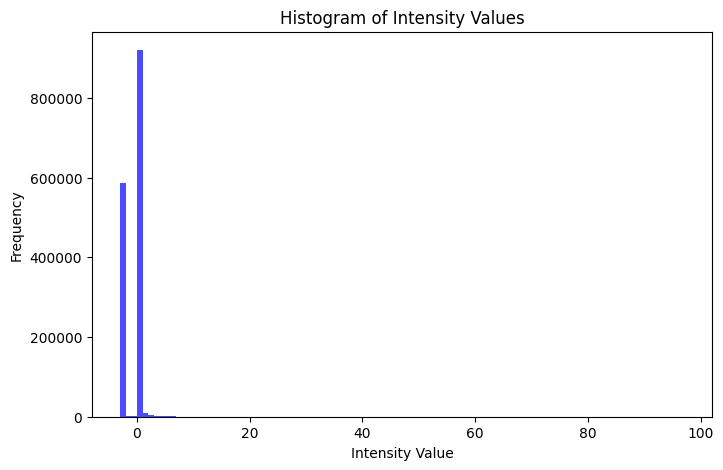

In [34]:
pixels = da_coarse.values.ravel()
plt.figure(figsize=(8,5))
plt.hist(pixels, bins=100, color='blue', alpha=0.7)
plt.title("Histogram of Intensity Values")
plt.xlabel("Intensity Value")
plt.ylabel("Frequency")
plt.show()

In [10]:
stored_range = range(1, 201)
export_folder = os.path.join(OUTPUT_PATH, "images")
os.makedirs(export_folder, exist_ok=True)

for time in tqdm(stored_range, desc="Processing files"):
    da = ds["unknown"].isel(time=time)  # 2D slice at first time index

    da_coarse = da.coarsen(latitude=3500//600, longitude=7000//800, boundary="trim").mean()
    export_file = os.path.join(export_folder, f"weather_{time}.npy")

    # plt.imsave(export_file, da_coarse.values, cmap="gray")
    np.save(export_file, da_coarse.values)

Processing files: 100%|██████████| 200/200 [00:51<00:00,  3.88it/s]
